Goal:

- show that our fitting procedure is robust to noise
- that an incorrect choice of initial parameters may give wrong results


In [1]:
from ANEMO import ANEMO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

# Loading eye movement data

In [2]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

# Creating a fitting procedure

In [3]:
fig_width=15/3
t_titre=35/2
t_label=20/2
dpi=400
block = 1

In [4]:
def regress(ax, p, data, minx, miny, maxx, maxy, t_label=12) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c='k', linewidth=2)
    ax.text(maxx-((maxx-minx)/16.180),miny+((maxy-miny)/10), 'r = %0.3f'%(r_), fontsize=t_label/1.2, ha='right')

    return ax

In [6]:
def fct_old_latency(data, time, w1=300, w2=50, off=50, crit=0.17) :
    
    from scipy import stats
    
    tps = time #np.arange(len(data))
    a = None
    for t in range(len(time)-(w1+off+w2)-300) :
        slope1, intercept1, r_, p_value, std_err = stats.linregress(tps[t:t+w1], data[t:t+w1])
        slope2, intercept2, r_, p_value, std_err = stats.linregress(tps[t+w1+off:t+w1+off+w2], data[t+w1+off:t+w1+off+w2])
        diff = abs(slope2) - abs(slope1)
        if abs(diff) >= crit :
            a = True
            tw = time[t:t+w1+off+w2]
            timew = np.linspace(np.min(tw), np.max(tw), len(tw))

            fitLine1 = slope1 * timew + intercept1
            fitLine2 = slope2 * timew + intercept2

            idx = np.argwhere(np.isclose(fitLine1, fitLine2, atol=0.1)).reshape(-1)
            old_latency = timew[idx]
            break
    
    if a is None :
        old_latency = [np.nan]

    return(old_latency[0])

In [7]:
def fit(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, step_fit, bruit,
        TargetOn, StimulusOf, start_sac=770, stop_sac=820):

    np.random.seed(7)
    
    param_fit={'tau':tau_fit, 'maxi':maxi_fit, 'a_anti':a_anti_fit, 'latency':latency_fit,
               'start_anti':start_anti_fit}
    
    result_fit={'start_anti_true':[], 'start_anti_fit':[], 'a_anti_true':[], 'a_anti_fit':[],
                'latency_true':[], 'latency_fit':[], 'bino':[], 'test':[],
                'tau_true':[], 'tau_fit':[], 'maxi_true':[], 'maxi_fit':[],
                'old_latency':[],'old_max':[], 'old_a_anti':[], 'old_a_anti_true':[], 'old_a_anti_fit':[],
                'v_lat_true':[], 'v_lat_fit':[]}
    
    for N_trial in range(200) :
        
        '''if N_trial <= 200 :
            block = 0
            trial = N_trial
        elif N_trial <= 400 :
            block = 1
            trial = N_trial-200
        else :
            block = 2
            trial = N_trial-400'''
        trial = N_trial
        print(block, trial)
        
        
        bino = exp['p'][trial][block][0]
        start_anti_true = param['start_anti'][block][trial]+TargetOn
        a_anti_true = param['a_anti'][block][trial]
        latency_true = param['latency'][block][trial]+TargetOn
        tau_true = param['tau'][block][trial]
        maxi_true = param['maxi'][block][trial]

        #------------------------------------------------------------------------------------
        true_test = ANEMO.fct_velocity(x, bino, start_anti_true, a_anti_true, latency_true, tau_true, maxi_true)
        test = ANEMO.fct_velocity(x, bino, start_anti_true, a_anti_true, latency_true, tau_true, maxi_true)+np.random.rand(len(x))*bruit
        test = test-np.random.rand(len(x))*bruit
        #test[start_sac:stop_sac] = np.arange(0, (stop_sac-start_sac), 1)*np.nan

        #------------------------------------------------------------------------------------
        result_deg = ANEMO.Fit_velocity(test, x, bino, param_fit=param_fit, sup=None, step=step_fit)

        
        start_anti_fit = result_deg.values['start_anti']
        a_anti_fit = result_deg.values['a_anti']
        latency_fit = result_deg.values['latency']
        tau_fit = result_deg.values['tau']
        maxi_fit = result_deg.values['maxi']
        
        best_fit = ANEMO.fct_velocity(x, bino, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit)
        #------------------------------------------------------------------------------------
        
        didi = (bino*2)-1
        result_fit['test'].append(test)
        result_fit['bino'].append(bino)
        
        result_fit['start_anti_true'].append(start_anti_true-TargetOn)
        result_fit['a_anti_true'].append(a_anti_true)
        result_fit['latency_true'].append(latency_true-TargetOn)
        result_fit['tau_true'].append(tau_true)
        result_fit['maxi_true'].append(abs((didi*maxi_true)+true_test[int(latency_true)])) #maxi_true)
        
        result_fit['start_anti_fit'].append(start_anti_fit-TargetOn)
        result_fit['a_anti_fit'].append(a_anti_fit)
        result_fit['latency_fit'].append(latency_fit-TargetOn)
        result_fit['tau_fit'].append(tau_fit)
        result_fit['maxi_fit'].append(abs((didi*maxi_fit)+best_fit[int(latency_fit)])) #result_deg.values['maxi']) #
        
        result_fit['v_lat_true'].append(true_test[int(latency_true)])
        result_fit['v_lat_fit'].append(best_fit[int(latency_fit)])
        
        #------------------------------------------------------------------------------------
        
        old_latency = fct_old_latency(test, x)
        
        if np.isnan(old_latency)==False :
            result_fit['old_latency'].append(old_latency-TargetOn)
        else :
            result_fit['old_latency'].append(old_latency)
        
        
        a1, b1 = TargetOn+400, TargetOn+600
        old_max = abs(np.nanmean(test[a1:b1]))
        result_fit['old_max'].append(old_max)
        
        result_fit['old_a_anti'].append(np.nanmean(test[TargetOn-50:TargetOn+50]))
        result_fit['old_a_anti_fit'].append(np.nanmean(best_fit[int(start_anti_fit):int(latency_fit)]))
        result_fit['old_a_anti_true'].append(np.nanmean(true_test[int(start_anti_true):int(latency_true)]))
        #------------------------------------------------------------------------------------
        
    return result_fit

In [8]:
x = np.arange(0, 1500, 1)
TargetOn, StimulusOf = 750, 750-300

In [9]:
def defaut():
    start_anti_fit = [TargetOn-100, StimulusOf-200, TargetOn+75]
    latency_fit = [TargetOn+100, TargetOn+75, len(x)]
    a_anti_fit = [0., -40., 40.]
    tau_fit = [15., 13., 80.]
    maxi_fit = [15., 1., 40.]

    return(start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit)

In [10]:
start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit = defaut()
result_fit = fit(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, 2, 10,TargetOn, StimulusOf)

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184


In [16]:
def start_tau(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf) :
       
    l = ['start_anti', 'tau']
    titre = ['Anticipation onset', r'$\tau$']
    label = ['Anticipation onset (ms)', r'$\tau$ (ms)']

    
    for b in range(2):
        fig, axs = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
        
        axs.set_title('%s'%(titre[b]), fontsize=t_titre, x=0.5, y=1.05)
        axs.set_xlabel('True %s'%label[b], fontsize=t_label)
        axs.set_ylabel('Fit %s'%label[b], fontsize=t_label)
        axs.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)

        axs.scatter(result_fit['%s_true'%l[b]], result_fit['%s_fit'%l[b]], c='r', alpha=0.5)
        
        min_x, min_y = min(result_fit['%s_true'%l[b]]), min(result_fit['%s_fit'%l[b]])
        max_x, max_y = max(result_fit['%s_true'%l[b]]), max(result_fit['%s_fit'%l[b]])
        
        axs = regress(axs, result_fit['%s_true'%l[b]], result_fit['%s_fit'%l[b]], min_x, min_y, max_x, max_y,  t_label=t_titre/1.5)
        
        axs.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
        #-----------------------------------------------------------------------------------
        plt.tight_layout()
        plt.savefig('../2018-05-04_Poster_Grenobe/test2/figures/%s_Full_%s.png'%(l[b],block), dpi=dpi)
        
    #-----------------------------------------------------------------------------------
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    axs1.set_title('Anticipatory onset for A$_a$ > 3°/s$^2$', fontsize=t_titre, x=0.5, y=1.05)
    axs1.set_xlabel('True Anticipation onset (ms)', fontsize=t_label)
    axs1.set_ylabel('Fit Anticipation onset (ms)', fontsize=t_label)
    axs1.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
    seuil = 3
    new_start_anti_fit = []
    new_start_anti_true = []
    for s in range(len(result_fit['start_anti_fit'])) :
        if abs(result_fit['a_anti_true'][s]) > seuil :
            if abs(result_fit['a_anti_fit'][s]) > seuil :
                new_start_anti_fit.append(result_fit['start_anti_fit'][s])
                new_start_anti_true.append(result_fit['start_anti_true'][s])
    
    axs1.scatter(new_start_anti_true, new_start_anti_fit, c='r', alpha=0.5)
    min_x, min_y = min(new_start_anti_true), min(new_start_anti_fit)
    max_x, max_y = max(new_start_anti_true), max(new_start_anti_fit)
    axs1 = regress(axs1, new_start_anti_true, new_start_anti_fit, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs1.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
    #-----------------------------------------------------------------------------------
    fig1.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/new_start_anti_Full_%s.png'%block, dpi=dpi)
    plt.show()
    
def latency(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf) :
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    fig2, axs2 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    #-----------------------------------------------------------------------------------
    axs1.set_ylabel('Fit Latency (ms)', fontsize=t_label)
    axs1.scatter(result_fit['latency_true'], result_fit['latency_fit'], c='r', alpha=0.5)
    #-----------------------------------------------------------------------------------
    axs2.set_ylabel('Classical Latency (ms)', fontsize=t_label)
    tutu = np.copy(result_fit['latency_true'])
    odo = np.copy(result_fit['old_latency'])
    tutu = tutu[~np.isnan(result_fit['old_latency'])]
    odo = odo[~np.isnan(result_fit['old_latency'])]
    axs2.scatter(tutu, odo, c='c', alpha=0.5)
    #-----------------------------------------------------------------------------------
    min_x1, min_y1 = min(result_fit['latency_true']), min(result_fit['latency_fit'])
    max_x1, max_y1 = max(result_fit['latency_true']), max(result_fit['latency_fit'])
    min_x2, min_y2 = min(tutu), min(odo)
    max_x2, max_y2 = max(tutu), max(odo)
    min_x, min_y = min(min_x1, min_x2), min(min_y1, min_y2)
    max_x, max_y = max(max_x1, max_x2), max(max_y1, max_y2)
    
    axs1 = regress(axs1, result_fit['latency_true'], result_fit['latency_fit'], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs2 = regress(axs2, tutu, odo, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    for a in [axs1, axs2] :
        a.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
        a.set_title('Latency of the pursuit', fontsize=t_titre, x=0.5, y=1.05)
        a.set_xlabel('True Latency (ms)', fontsize=t_label)
        a.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
    #-----------------------------------------------------------------------------------
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/latency_Full_%s.png'%block, dpi=dpi)
    fig2.savefig('../2018-05-04_Poster_Grenobe/test2/figures/old_latency_Full_%s.png'%block, dpi=dpi)
    plt.show()


def A_a(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf) :
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    fig2, axs2 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    #-----------------------------------------------------------------------------------
    axs1.set_ylabel('Fit A$_a$ (°/s$^2$)', fontsize=t_label)
    axs1.scatter(result_fit['a_anti_true'], result_fit['a_anti_fit'], c='r', alpha=0.5)
    #-----------------------------------------------------------------------------------
    axs2.set_ylabel('Classical A$_a$ (°/s$^2$)', fontsize=t_label)
    lala = (result_fit['old_a_anti'])/(np.ones(len(result_fit['old_a_anti']))*0.1)
    axs2.scatter(result_fit['a_anti_true'], lala, c='c', alpha=0.5)
    #-----------------------------------------------------------------------------------
    min_y1, max_y1 = min(result_fit['a_anti_fit']), max(result_fit['a_anti_fit'])
    min_y2,max_y2 = min(lala), max(lala)
    min_x, min_y = min(result_fit['a_anti_true']), min(min_y1, min_y2)
    max_x, max_y = max(result_fit['a_anti_true']), max(max_y1, max_y2)
    
    axs1 = regress(axs1, result_fit['a_anti_true'], result_fit['a_anti_fit'], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs2 = regress(axs2, result_fit['a_anti_true'], lala, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    
    
    for a in [axs1, axs2] :
        a.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
        a.set_title('Anticipatory acceleration', fontsize=t_titre, x=0.5, y=1.05) #Acceleration of anticipation
        a.set_xlabel('True A$_a$ (°/s$^2$)', fontsize=t_label)
        a.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
    #------------------------------------------------------------------------------------
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/a_anti_Full_%s.png'%block, dpi=dpi)
    fig2.savefig('../2018-05-04_Poster_Grenobe/test2/figures/old_a_anti_Full_%s.png'%block, dpi=dpi)
    plt.show()


def Maxi(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf) :
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    fig2, axs2 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    #------------------------------------------------------------------------------------
    matrue = np.copy(result_fit['maxi_true'])
    mafit = np.copy(result_fit['maxi_fit'])
    maold = np.copy(result_fit['old_max'])
    matrue = matrue.tolist()
    mafit = mafit.tolist()
    maold = maold.tolist()
    del mafit[np.argmin(matrue)]
    del maold[np.argmin(matrue)]
    del matrue[np.argmin(matrue)]
    #-----------------------------------------------------------------------------------
    axs1.set_ylabel('Fit Steady-state (°/s)', fontsize=t_label)
    axs1.scatter(matrue, mafit, c='r', alpha=0.5)
    #-----------------------------------------------------------------------------------
    axs2.set_ylabel('Classical Steady-state (°/s)', fontsize=t_label)
    axs2.scatter(matrue, maold, c='c', alpha=0.5)
    #-----------------------------------------------------------------------------------
    min_y1, max_y1 = min(mafit), max(mafit)
    min_y2, max_y2 = min(maold), max(maold)
    min_x, min_y = min(matrue), min(min_y1, min_y2)
    max_x, max_y = max(matrue), max(max_y1, max_y2)
    
    axs1 = regress(axs1, matrue, mafit, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs2 = regress(axs2, matrue, maold, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    
    
    for a in [axs1, axs2] :
        a.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
        a.set_title('Steady-state velocity', fontsize=t_titre, x=0.5, y=1.05) #steady-state velocity
        a.set_xlabel('True Steady-state (°/s)', fontsize=t_label)
        a.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])    
    #------------------------------------------------------------------------------------
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/maxi_Full_%s.png'%block, dpi=dpi)    
    fig2.savefig('../2018-05-04_Poster_Grenobe/test2/figures/old_max_Full_%s.png'%block, dpi=dpi)
    plt.show()

def V_a(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf) :
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    fig2, axs2 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    #-----------------------------------------------------------------------------------
    axs1.set_ylabel('Fit V$_a$ (°/s)', fontsize=t_label)
    axs1.scatter(result_fit['old_a_anti_true'], result_fit['old_a_anti_fit'], c='r', alpha=0.5)
    #-----------------------------------------------------------------------------------
    axs2.set_ylabel('Classical V$_a$ (°/s)', fontsize=t_label)
    axs2.scatter(result_fit['old_a_anti_true'], result_fit['old_a_anti'], c='c', alpha=0.5)
    #-----------------------------------------------------------------------------------
    min_y1, max_y1 = min(result_fit['old_a_anti_fit']), max(result_fit['old_a_anti_fit'])
    min_y2, max_y2 = min(result_fit['old_a_anti']), max(result_fit['old_a_anti'])
    min_x, min_y = min(result_fit['old_a_anti_true']), min(min_y1, min_y2)
    max_x, max_y = max(result_fit['old_a_anti_true']), max(max_y1, max_y2)
    
    axs1 = regress(axs1, result_fit['old_a_anti_true'], result_fit['old_a_anti_fit'], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs2 = regress(axs2, result_fit['old_a_anti_true'], result_fit['old_a_anti'], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    
    
    for a in [axs1, axs2] :
        a.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
        a.set_title('Anticipatory velocity', fontsize=t_titre, x=0.5, y=1.05) #Velocity of anticipation
        a.set_xlabel('True V$_a$ (°/s)', fontsize=t_label)
        a.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)]) 
    
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/old_a_anti_fit_true_Full_%s.png'%block, dpi=dpi)    
    fig2.savefig('../2018-05-04_Poster_Grenobe/test2/figures/old_a_anti_true_classique_Full_%s.png'%block, dpi=dpi)
    plt.show()
    
def V_lat(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf) :
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width*1, (fig_width*1)/1.6180))
    
    axs1.plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
    axs1.set_title('Velocity of onset', fontsize=t_titre, x=0.5, y=1.05) #velocity at visually-guided pursuit initiation
    
    axs1.set_xlabel('True V$_{onset}$ (°/s)', fontsize=t_label)
    axs1.set_ylabel('Fit V$_{onset}$ (°/s)', fontsize=t_label)
    axs1.scatter(result_fit['v_lat_true'], result_fit['v_lat_fit'], c='r', alpha=0.5)
    #-----------------------------------------------------------------------------------
    min_x, min_y = min(result_fit['v_lat_true']), min(result_fit['v_lat_fit'])
    max_x, max_y = max(result_fit['v_lat_true']), max(result_fit['v_lat_fit'])
    
    axs1 = regress(axs1, result_fit['v_lat_true'], result_fit['v_lat_fit'], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs1.axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)]) 
    
    fig1.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/v_lat_Full_%s.png'%block, dpi=dpi)    
    plt.show()

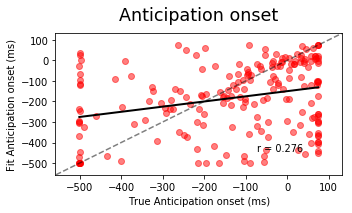

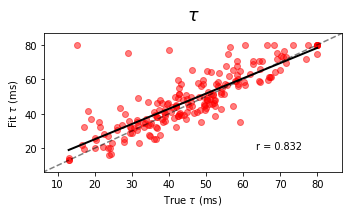

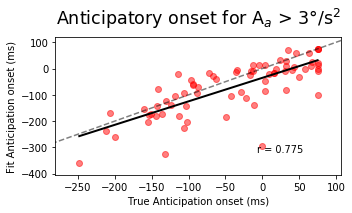

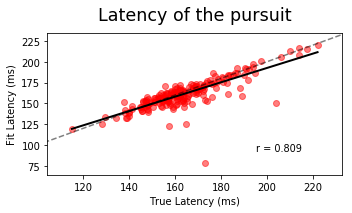

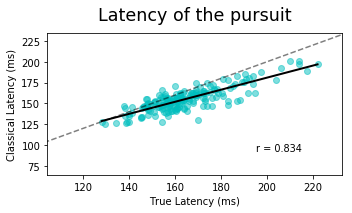

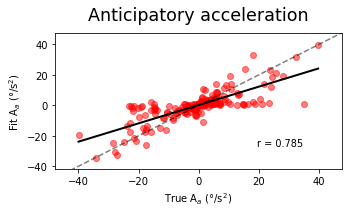

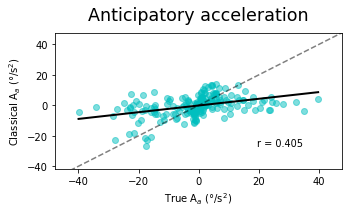

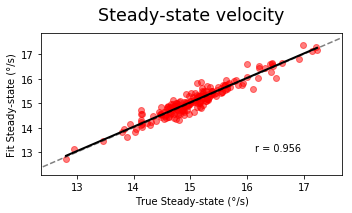

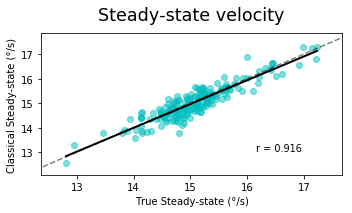

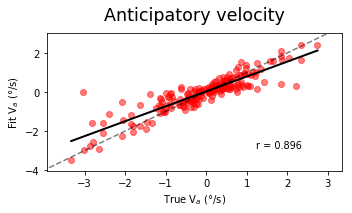

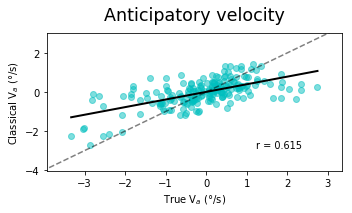

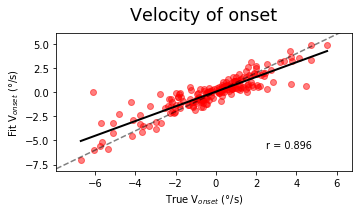

In [17]:
start_tau(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf)
latency(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf)
A_a(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf)
Maxi(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf)
V_a(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf)
V_lat(x, result_fit, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, TargetOn, StimulusOf)